In [1]:
from os import listdir, path, mkdir
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pygrib
import numpy as np
import xarray as xr
import datetime as dt
import requests
from tqdm import tqdm
cdf_path = '/mnt/c/Users/bpara/uems/runs/1993blizzard/wrfprd'
prep_path = '/mnt/c/Users/bpara/uems/runs/1993blizzard/wpsprd'
grib_path = '/mnt/c/Users/bpara/uems/runs/1993blizzard/grib'
test_path = 'data/1844/pressure_levels'
test_path_2 = 'data/1844/subsurface'

In [2]:
def get_file_by_url(url, file_name, overwrite=False):
    if path.exists(file_name) and not overwrite:
        return
    response = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(response.content)

In [3]:
def create_dir(path_to_dir):
    if path.exists(path_to_dir):
        return
    else:
        mkdir(path_to_dir)

In [4]:
def nc_to_grb(input_path, output_path):
    import cdo
    cdo=cdo.Cdo(tempdir='tmp')
    cdo.setmissval('-9.e16', input=input_path, output='t.nc')
    cdo.copy(input='t.nc', output=output_path,  options = '-f grb2')

In [5]:
def download_reanalysis_year(year, local_path='data', verbose=False, overwrite=False):
    #define a bunch of constants refering to where these datasets are stored on the NOAA servers
    year_id = 'SI' if year < 1981 else 'MO'
    DATA_SUBSETS = ['mean_sea_level', 'pressure_levels', 'subsurface', 'two_meters', 'tropopause']
    DATA_PATHS   = [f'misc{year_id}', f'prs{year_id}', f'subsfc{year_id}', f'tropo{year_id}', f'2m{year_id}']
    BASE_URL = 'https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3'
    
    MSL_FILES = [f'prmsl.{year}.nc']
    PL_FILES = [f'air.{year}.nc', f'hgt.{year}.nc', f'rhum.{year}.nc', f'uwnd.{year}.nc', f'vwnd.{year}.nc']
    SS_FILES = [f'soill.{year}.nc', f'soilw.{year}.nc', f'tsoil.{year}.nc']
    TP_FILES = [f'air.tropo.{year}.nc', f'hgt.tropo.{year}.nc', f'pres.tropo.{year}.nc', f'uwnd.tropo.{year}.nc', f'vwnd.tropo.{year}.nc']
    TM_FILES = [f'air.2m.{year}.nc', f'rhum.2m.{year}.nc']
    
    MASTER_FILE_LIST = [MSL_FILES, PL_FILES, SS_FILES, TP_FILES, TM_FILES]
    
    #unlike the others, the surface variables are in a couple of different repositories, so they are accessed differently
    SURFACE_PATHS = [f'sfc{year_id}/cnwat.{year}.nc', f'timeInvariant{year_id}/land.nc', f'sfc{year_id}/pres.sfc.{year}.nc', 
                     f'sfc{year_id}/skt.{year}.nc', f'accums{year_id}/snod.{year}.nc', f'sfc{year_id}/snowc.{year}.nc', 
                     f'sfc_params{year_id}/veg.{year}.nc', f'accums{year_id}/weasd.{year}.nc']
    
    #download everything save the surface variables
    create_dir(f'{local_path}/{year}')
    for directory, noaa_path, file_list in zip(DATA_SUBSETS, DATA_PATHS, MASTER_FILE_LIST):
        create_dir(f'{local_path}/{year}/{directory}')
        for file in file_list:
            if verbose:
                print(f'Downloading {noaa_path}/{file}')
            get_file_by_url(f'{BASE_URL}/{noaa_path}/{file}', f'{local_path}/{year}/{directory}/{file}', overwrite=overwrite)
    
    #and now for the surface variables
    create_dir(f'{local_path}/{year}/surface')
    for path_file in SURFACE_PATHS:
        get_file_by_url(f'{BASE_URL}/{path_file}', f'{local_path}/{year}/surface/{path_file.split("/")[1]}', overwrite=overwrite)

In [6]:
#as I add more exceptions this is rapidly becoming spaghetti code. Will have to fix at some point
def get_data_at_datetime(datetime, local_path='data'):
    year = datetime.year
    DATA_SUBSETS = ['pressure_levels', 'surface', 'two_meters', 'subsurface', 'tropopause', 'mean_sea_level']
    temp_nc_paths = []
    for subset in DATA_SUBSETS:
        print(subset)
        merge_list = []
        for file in listdir(f'{local_path}/{year}/{subset}'):
            if file == '.ipynb_checkpoints':
                continue
            #handle a couple of odd points here. Tsoil isn't saved correctly on the noaa side, leading to grib errors
            if file == f'tsoil.{year}.nc':
                temp = xr.open_dataset(f'{local_path}/{year}/{subset}/{file}', engine='netcdf4').sel({'time':datetime})
                temp['tsoil'].attrs['standard_name'] = 'soil_temperature'
                temp['tsoil'].attrs['long_name'] = 'Soil temperature'
                temp['tsoil'].attrs['param'] = '2.0.2'
                merge_list.append(temp)
            elif file == 'land.nc':
                #and land is (on this timescale) invariant, so we don't select its time
                merge_list.append(xr.open_dataset(f'{local_path}/{year}/{subset}/{file}', engine='netcdf4'))
            else:
                merge_list.append(xr.open_dataset(f'{local_path}/{year}/{subset}/{file}', engine='netcdf4').sel({'time':datetime}))
        if subset == 'two_meters':
            temp = xr.merge(merge_list).drop_vars(['time', 'time_bnds'])
            temp = temp.expand_dims({'height': [2]})
            height_attrs = {'standard_name': 'height', 'axis': 'Z', 'units': 'm', 'positive': 'upwards'}
            temp['height'].attrs = height_attrs
        elif subset == 'subsurface':
            temp = xr.merge(merge_list).drop_vars('time').rename({'level': 'depth'})
            temp['depth'].attrs['standard_name'] = 'depth'
            temp['depth'].attrs['long_name'] = 'depth_below_land'
            temp['depth'].attrs['zaxistype'] = 'depth_below_land'
        elif subset == 'tropopause':
            temp = xr.merge(merge_list).drop_vars('time')
            for var in temp.variables:
                if var != 'lat' and var != 'lon':
                    temp[var].attrs['level_type'] = 'tropopause'
            temp.to_netcdf(f'tmp/{subset}.nc')
        elif subset == 'mean_sea_level':
            temp = xr.merge(merge_list).drop_vars('time')
            temp = temp.expand_dims({'meanSea': [0]})
            height_attrs = {'standard_name': 'mean_sea_level', 'long_name': 'Mean Sea Level'}
            temp['meanSea'].attrs = height_attrs
            for var in temp.variables:
                if var != 'lat' and var != 'lon':
                    temp[var].attrs['level_type'] = 'mean_sea_level'
        elif subset == 'surface':
            temp = xr.merge(merge_list).drop_vars('time')
            temp = temp.rename({'snod': 'sde', 'weasd': 'sdwe'})
        else:
            temp = xr.merge(merge_list).drop_vars('time')
        temp.to_netcdf(f'tmp/{subset}.nc')
        nc_to_grb(f'tmp/{subset}.nc', f'grib_output/{subset}.grb2')

In [7]:
time = dt.datetime(year=1844, month=1, day=1)

In [8]:
get_data_at_datetime(time)

pressure_levels
surface
two_meters
subsurface
tropopause
mean_sea_level


In [ ]:
%%time
download_reanalysis_year(1993)

xr.open_dataset('data/1844/subsurface/soilw.1844.nc')

In [9]:
xr.open_dataset('tmp/two_meters.nc')

<xarray.Dataset>
Dimensions:  (height: 1, lat: 181, lon: 360)
Coordinates:
  * height   (height) int64 2
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    air      (height, lat, lon) float32 ...
    rhum     (height, lat, lon) float32 ...
Attributes: (12/24)
    Conventions:               CF-1.2
    title:                     8x Daily NOAA/CIRES/DOE 20th Century Reanalysi...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    spatial_resolution:        1.0 degree
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...

In [13]:
xr.open_dataset('t.nc')

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, meanSea: 1)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * meanSea  (meanSea) float64 0.0
Data variables:
    prmsl    (meanSea, lat, lon) float32 ...
Attributes: (12/26)
    CDI:                       Climate Data Interface version 2.1.0 (https://...
    Conventions:               CF-1.2
    source:                    20CRv3si 2018, Ensemble Kalman Filter, ocean (...
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    title:                     8x Daily NOAA/CIRES/DOE 20th Century Reanalysi...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...
    CDO:                       Climate Data Operators version 2.1.0 (https://...

In [11]:
#listdir(grib_path)
'''
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'tropopause'}
    filter_by_keys={'typeOfLevel': 'maxWind'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
'''
grb = xr.open_dataset(f'{grib_path}/1993031206.cfsr.t06z.pgrb2f00', engine='cfgrib', 
                      backend_kwargs={'filter_by_keys': {'typeOfLevel': 'depthBelowLandLayer'}})
grb

skipping variable: paramId==3086 shortName='ssw'
Traceback (most recent call last):
  File "/home/bparazin/anaconda3/envs/1844redux/lib/python3.10/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/bparazin/anaconda3/envs/1844redux/lib/python3.10/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=('depthBelowLandLayer',), data=array([0. , 0.1, 0.4, 1. ])) new_value=Variable(dimensions=(), data=0.0)


<xarray.Dataset>
Dimensions:              (depthBelowLandLayer: 4, latitude: 361, longitude: 720)
Coordinates:
    time                 datetime64[ns] ...
    step                 timedelta64[ns] ...
  * depthBelowLandLayer  (depthBelowLandLayer) float64 0.0 0.1 0.4 1.0
  * latitude             (latitude) float64 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * longitude            (longitude) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
    valid_time           datetime64[ns] ...
Data variables:
    soilw                (depthBelowLandLayer, latitude, longitude) float32 ...
    t                    (depthBelowLandLayer, latitude, longitude) float32 ...
    soill                (depthBelowLandLayer, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-11-01T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

NameError: name 'lon' is not defined

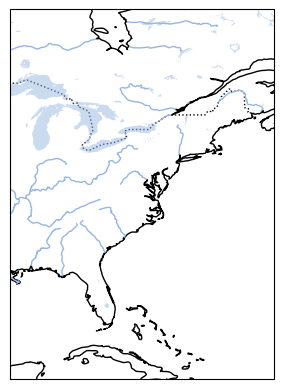

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([-65, -90, 20, 55], crs=ccrs.PlateCarree())
im = ax.pcolor(lon, lat, pert_geo)
plt.colorbar(im)

In [ ]:
data = Dataset(f'{cdf_path}/wrfout_d01_1993-03-15_00:00:00', 'r')
pert_geo = data['PH'][0, 3, :]
temp = data['T2'][0, :]
lat = data['XLAT'][0, :]
lon = data['XLONG'][0, :]
#data.close()

In [ ]:
np.shape(rain), np.shape(temp)

In [ ]:
data.variables

cdo -f grb -copy test.nc test.grb

https://github.com/eengl/grib2io

In [ ]:
test2 = xr.open_dataset('data/1844/subsurface/tsoil.1844.nc')

In [ ]:

test2

In [ ]:
test2 = test2.rename({'air': 't'})

In [ ]:
test2.to_netcdf('test2.nc')

In [ ]:
nc_to_grb('test2.nc', 'test2.grb')

In [ ]:
xr.open_dataset('/mnt/c/Users/bpara/uems/data/930312/grib/9303120000_wrfout_arw_d01.grb2f000000', engine="cfgrib", 
                filter_by_keys={'typeOfLevel': 'tropopause'})

In [ ]:
test2

In [ ]:
import cdo
cdo=cdo.Cdo(tempdir='tmp')
cdo.copy(input='/mnt/c/Users/bpara/uems/data/930312/grib/9303120000_wrfout_arw_d01.grb2f000000', output='test.nc',  options = '-f nc')

In [ ]:
xr.open_dataset('test.nc')

In [ ]:
nc_to_grb('test.nc', 'test.grb2')

In [ ]:
xr.open_dataset('/mnt/c/Users/bpara/uems/data/930312/grib/9303120000_wrfout_arw_d01.grb2f000000', 
                engine="cfgrib", filter_by_keys={'typeOfLevel': 'meanSea'})

In [ ]:
'''
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
filter_by_keys={'typeOfLevel': 'heightAboveGround'}
filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
filter_by_keys={'typeOfLevel': 'isobaricLayer'}
filter_by_keys={'typeOfLevel': 'isobaricInPa'}
filter_by_keys={'typeOfLevel': 'atmosphere'}
filter_by_keys={'typeOfLevel': 'cloudBase'}
filter_by_keys={'typeOfLevel': 'tropopause'}
filter_by_keys={'typeOfLevel': 'isothermZero'}
filter_by_keys={'typeOfLevel': 'depthBelowLand'}
filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
'''
xr.open_dataset('test.grb2', engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

In [ ]:
xr.open_dataset('tmp/surface.nc')

In [14]:
xr.open_dataset('grib_output/mean_sea_level.grb2', engine="cfgrib")

Ignoring index file 'grib_output/mean_sea_level.grb2.923a8.idx' older than GRIB file
/home/bparazin/anaconda3/envs/1844redux/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bparazin/anaconda3/envs/1844redux/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bparazin/anaconda3/envs/1844redux/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: date

<xarray.Dataset>
Dimensions:       (latitude: 181, longitude: 360)
Coordinates:
    time          object ...
    step          timedelta64[ns] ...
    isobaricInPa  float64 ...
  * latitude      (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * longitude     (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time    object ...
Data variables:
    prmsl         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             0
    GRIB_centreDescription:  WMO Secretariat
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             WMO Secretariat
    history:                 2022-11-01T11:03 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
test = xr.open_dataset('t.nc')

In [ ]:
test

In [ ]:
test2 = test.assign(variables={'level': test['level'].values * -1})
test2['level'].attrs = test['level'].attrs

In [ ]:
test2

In [ ]:
import cdo
cdo=cdo.Cdo(tempdir='tmp')
cdo.merge(input=[f'grib_output/{file}' for file in listdir('grib_output')], output='test.grb2')

In [ ]:
"""
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'depthBelowLand'}
    filter_by_keys={'typeOfLevel': 'tropopause'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
"""

xr.open_dataset('test.grb2', engine='cfgrib', filter_by_keys={'typeOfLevel': 'surface'})